In [ ]:

print("Installing required libraries...")
!pip install -q transformers torch accelerate scikit-learn pandas
print("--> Libraries installed successfully.")

Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00:00:0100:01
--> Libraries installed successfully.


In [ ]:
# --- Cell 2: Imports and Model Loading (Corrected) ---

print("Importing libraries and loading the Image-to-Text model...")
from transformers import BlipProcessor, BlipForConditionalGeneration
from sklearn.cluster import KMeans
from PIL import Image
import torch
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


import cv2

MODEL_NAME = "Salesforce/blip-image-captioning-base"

try:
    processor = BlipProcessor.from_pretrained(MODEL_NAME)
    model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME)
    print("--> BLIP Image-to-Text model and processor loaded successfully.")
except Exception as e:
    print(f"!!! ERROR loading BLIP model: {e}")
    print("!!! Please ensure your Kaggle notebook has internet access enabled in the settings.")
    raise

Importing libraries and loading the Image-to-Text model...


2025-07-19 16:16:16.719467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752941776.922233      74 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752941776.981365      74 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

--> BLIP Image-to-Text model and processor loaded successfully.


In [ ]:
# --- Cell 3: Define the Color Detection and Captioning Functions ---

print("Defining the analysis functions...")

def get_dominant_color(image, k=5, min_saturation=20):
    """
    Finds the dominant color in a PIL image, ignoring pure white/black/grey pixels.
    
    Args:
        image (PIL.Image): The image to analyze.
        k (int): The number of clusters to form.
        min_saturation (int): The minimum saturation for a color to be considered non-neutral.

    Returns:
        tuple: (R, G, B) values of the dominant color.
    """
    # Resize for faster processing and convert to NumPy array
    img_small = image.resize((100, 100))
    pixels = np.array(img_small)
    pixels = pixels.reshape(-1, 3)

    
    pixels_hsv = cv2.cvtColor(np.uint8([pixels]), cv2.COLOR_RGB2HSV)[0]
    saturated_pixels = pixels[pixels_hsv[:, 1] > min_saturation]
    
    if len(saturated_pixels) < k:
        saturated_pixels = pixels
    
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(saturated_pixels)
    
    # Find the most frequent cluster
    unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_cluster_index = unique_labels[np.argmax(counts)]
    
    dominant_color = kmeans.cluster_centers_[dominant_cluster_index].astype(int)
    return tuple(dominant_color)


def generate_caption(image, model, processor):
    """
    Generates a descriptive text caption for a given image using the BLIP model.
    """
    inputs = processor(images=image, return_tensors="pt")
    
    # Generate the output IDs (the text)
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_length=50)
    
    caption = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    
    if caption.startswith("a photography of"):
        caption = caption.replace("a photography of", "A", 1).strip()
    
    return caption

print("--> Color detection and image captioning functions are ready.")

Defining the analysis functions...
--> Color detection and image captioning functions are ready.



--- Testing the combined analysis on 5 sample images ---


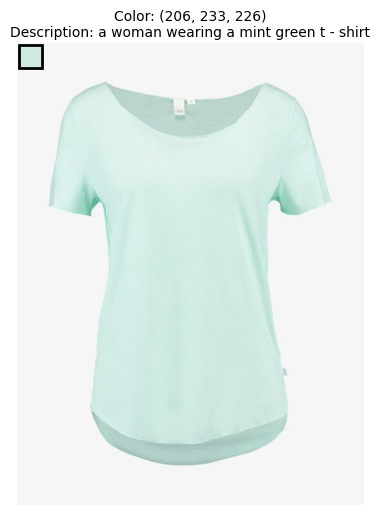

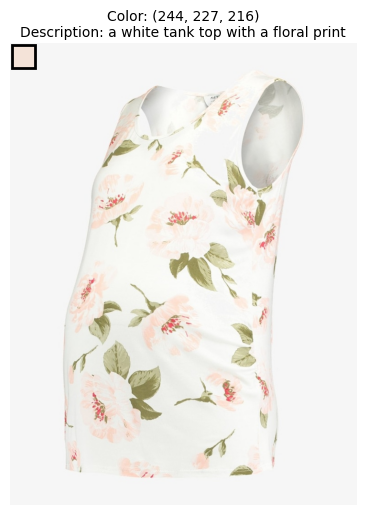

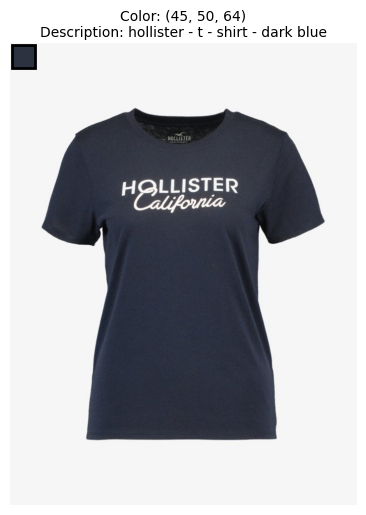

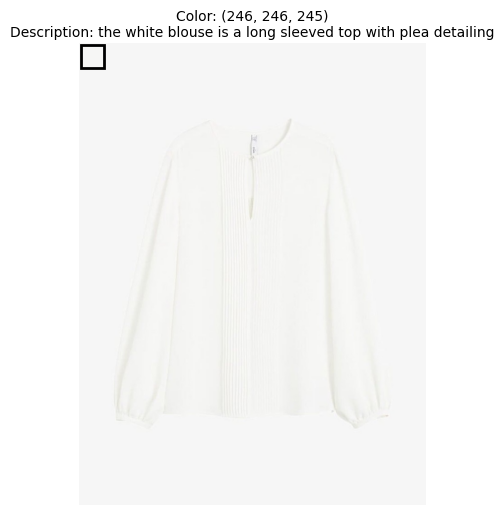

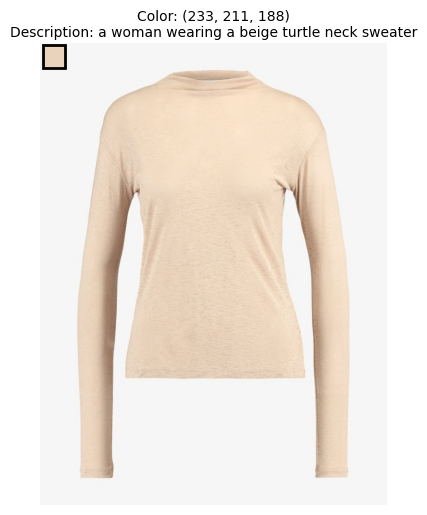

In [ ]:

CLOTH_DATABASE_PATH = '/kaggle/input/clothestry/clothes_tryon_dataset/train/cloth'
try:
    sample_filenames = [os.path.join(CLOTH_DATABASE_PATH, f) for f in os.listdir(CLOTH_DATABASE_PATH)[:5]]
except FileNotFoundError:
    print(f"\n!!! ERROR: Could not find the cloth database at {CLOTH_DATABASE_PATH}")
    sample_filenames = []

print("\n--- Testing the combined analysis on 5 sample images ---")
for image_path in sample_filenames:
    try:
        image = Image.open(image_path).convert("RGB")
        
        # 1. Get the dominant color
        dominant_color = get_dominant_color(image)
        
        # 2. Generate the caption
        caption = generate_caption(image, model, processor)
        
        # Display the results
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(image)
        title_text = f"Color: {dominant_color}\nDescription: {caption}"
        ax.set_title(title_text, fontsize=10, wrap=True)
        
        # Create a color patch to show the detected dominant color
        color_patch = plt.Rectangle((5, 5), 50, 50, color=np.array(dominant_color)/255.0, ec='black', lw=2)
        ax.add_patch(color_patch)
        ax.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Could not process {image_path}: {e}")

In [ ]:

print("Starting color and description analysis for the entire dataset...")
print("(This may take some time depending on the number of images)")

CLOTH_DATABASE_PATH = '/kaggle/input/clothestry/clothes_tryon_dataset/train/cloth'
OUTPUT_PATH = '/kaggle/working/'
if not os.path.exists(CLOTH_DATABASE_PATH):
    raise SystemExit(f"!!! FATAL ERROR: Dataset path not found at '{CLOTH_DATABASE_PATH}'")

all_cloth_files = [os.path.join(CLOTH_DATABASE_PATH, f) for f in sorted(os.listdir(CLOTH_DATABASE_PATH))]

results = []
# Loop through all files with a tqdm progress bar
for image_path in tqdm(all_cloth_files, desc="Analyzing All Images"):
    try:
        image = Image.open(image_path).convert("RGB")
        
        # Get both pieces of information
        color = get_dominant_color(image)
        caption = generate_caption(image, model, processor)
        
        results.append({
            "filename": os.path.basename(image_path),
            "dominant_color_rgb": f"({color[0]}, {color[1]}, {color[2]})",
            "description": caption
        })
    except Exception as e:
        print(f"Warning: Could not process {image_path}. Error: {e}")
        results.append({
            "filename": os.path.basename(image_path),
            "dominant_color_rgb": "Error",
            "description": f"Processing_Error: {e}"
        })

description_df = pd.DataFrame(results)

output_csv_path = os.path.join(OUTPUT_PATH, 'cloth_description_profile.csv')
description_df.to_csv(output_csv_path, index=False)

print("\n\n--- Analysis Complete! ---")
print(f"Results for all {len(description_df)} items have been saved to: '{output_csv_path}'")

print("\nFirst 10 rows of the generated description profile:")
pd.set_option('display.max_colwidth', None)
display(description_df.head(10))

print("\n--- SCRIPT FINISHED ---")

Starting color and description analysis for the entire dataset...
(This may take some time depending on the number of images)


Analyzing All Images:  59%|█████▉    | 6870/11647 [3:25:34<2:27:35,  1.85s/it]/tmp/ipykernel_74/1119258995.py:34: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(saturated_pixels)
Analyzing All Images:  83%|████████▎ | 9697/11647 [4:50:48<57:55,  1.78s/it]  /tmp/ipykernel_74/1119258995.py:34: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(saturated_pixels)
Analyzing All Images: 100%|██████████| 11647/11647 [5:48:43<00:00,  1.80s/it]  



--- Analysis Complete! ---
Results for all 11647 items have been saved to: '/kaggle/working/cloth_description_profile.csv'

First 10 rows of the generated description profile:


,filename,dominant_color_rgb,description
0,00000_00.jpg,"(181, 50, 70)",levi logo t - shirt
1,00001_00.jpg,"(33, 34, 38)",a black t - shirt with a red logo on the chest
2,00002_00.jpg,"(15, 15, 17)",long sleeve - long sleeved top - black
3,00003_00.jpg,"(26, 28, 44)",a woman wearing a navy t - shirt with a pocket
4,00005_00.jpg,"(240, 206, 208)",levis - t - shirt - white
5,00007_00.jpg,"(209, 191, 203)",adidas 3 stripes tee - t - shirt - lila
6,00009_00.jpg,"(21, 23, 22)",pu tee - t - shirt - black
7,00010_00.jpg,"(18, 21, 22)",calvin jeans - t - shirt - black
8,00011_00.jpg,"(20, 19, 20)",adidas - body - black / white
9,00012_00.jpg,"(21, 22, 24)",a black sweatshirt with the word obey on it



--- SCRIPT FINISHED ---
